<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#0.-Import" data-toc-modified-id="0.-Import-1">0. Import</a></span></li><li><span><a href="#1.-Датасет" data-toc-modified-id="1.-Датасет-2">1. Датасет</a></span><ul class="toc-item"><li><span><a href="#1.1-Описание-признаков" data-toc-modified-id="1.1-Описание-признаков-2.1">1.1 Описание признаков</a></span></li><li><span><a href="#1.2-Считывание-датасета" data-toc-modified-id="1.2-Считывание-датасета-2.2">1.2 Считывание датасета</a></span></li><li><span><a href="#1.3-Выбросы" data-toc-modified-id="1.3-Выбросы-2.3">1.3 Выбросы</a></span></li><li><span><a href="#1.4-Выбор-признаков" data-toc-modified-id="1.4-Выбор-признаков-2.4">1.4 Выбор признаков</a></span></li></ul></li><li><span><a href="#2.-AutoML" data-toc-modified-id="2.-AutoML-3">2. AutoML</a></span></li><li><span><a href="#3.-Модели" data-toc-modified-id="3.-Модели-4">3. Модели</a></span><ul class="toc-item"><li><span><a href="#3.1-LogisticRegression" data-toc-modified-id="3.1-LogisticRegression-4.1">3.1 LogisticRegression</a></span></li><li><span><a href="#3.2-LinearRegression" data-toc-modified-id="3.2-LinearRegression-4.2">3.2 LinearRegression</a></span></li><li><span><a href="#3.3-RandomForestClassifier" data-toc-modified-id="3.3-RandomForestClassifier-4.3">3.3 RandomForestClassifier</a></span></li><li><span><a href="#3.4-LGBMClassifier" data-toc-modified-id="3.4-LGBMClassifier-4.4">3.4 LGBMClassifier</a></span></li><li><span><a href="#3.5-XGBClassifier" data-toc-modified-id="3.5-XGBClassifier-4.5">3.5 XGBClassifier</a></span></li><li><span><a href="#3.6-CatBoost" data-toc-modified-id="3.6-CatBoost-4.6">3.6 CatBoost</a></span></li><li><span><a href="#3.7-NN" data-toc-modified-id="3.7-NN-4.7">3.7 NN</a></span></li></ul></li><li><span><a href="#4.-Результаты" data-toc-modified-id="4.-Результаты-5">4. Результаты</a></span><ul class="toc-item"><li><span><a href="#4.1-Таблица-результатов" data-toc-modified-id="4.1-Таблица-результатов-5.1">4.1 Таблица результатов</a></span></li><li><span><a href="#4.2-Выбор-оптимального-порога-для-лучшей-модели" data-toc-modified-id="4.2-Выбор-оптимального-порога-для-лучшей-модели-5.2">4.2 Выбор оптимального порога для лучшей модели</a></span></li><li><span><a href="#4.3-Выводы" data-toc-modified-id="4.3-Выводы-5.3">4.3 Выводы</a></span></li></ul></li></ul></div>

# 0. Import

In [1]:
import pandas as pd, numpy as np, re, scipy.stats as stats
import seaborn as sns, matplotlib.pyplot as plt, plotly.express as px
from collections import Counter
from tqdm import tqdm, tqdm_notebook
from datetime import datetime

from sklearn import decomposition
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, log_loss
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectPercentile
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks


import optuna


import warnings
warnings.filterwarnings('ignore')

# 1. Датасет

## 1.1 Описание признаков

TCS_CUSTOMER_ID	Идентификатор клиента	ID

BUREAU_CD	Код бюро, из которого получен счет	numeric

BKI_REQUEST_DATE	Дата, в которую был сделан запрос в бюро	date

CURRENCY	Валюта договора (ISO буквенный код валюты)	string

RELATIONSHIP	Тип отношения к договору	string
	1 - Физическое лицо	
	2 - Дополнительная карта/Авторизованный пользователь	
	4 - Совместный 	
	5 - Поручитель	
	9 - Юридическое лицо	
    
OPEN_DATE	Дата открытия договора	date

FINAL_PMT_DATE	Дата финального платежа (плановая)	date

TYPE	Код типа договора	string
	1 – Кредит на автомобиль	
	4 – Лизинг. Срочные платежи за наем/пользование транспортным средством, предприятием или оборудованием и т.п.	
	6 – Ипотека – ссудные счета, имеющие отношение к домам, квартирам и прочей недвижимости. Ссуда выплачивается циклично согласно договоренности до тех пор, пока она не будет полностью выплачена или возобновлена. 	
	7 – Кредитная карта 	
	9 – Потребительский кредит	
	10 – Кредит на развитие бизнеса	
	11 – Кредит на пополнение оборотных средств	
	12 – Кредит на покупку оборудования 	
	13 – Кредит на строительство недвижимости	
	14 – Кредит на покупку акций (например, маржинальное кредитование)	
	99 – Другой	
    
PMT_STRING_84M	Дисциплина (своевременность) платежей. Строка составляется из кодов состояний счета на моменты передачи банком данных по счету в бюро, первый символ - состояние на дату PMT_STRING_START, далее последовательно в порядке убывания дат.	string
	0 – Новый, оценка невозможна	
	X – Нет информации	
	1 – Оплата без просрочек	
	A – Просрочка от 1 до 29 дней	
	2 – Просрочка от 30 до 59 дней	
	3 – Просрочка от 60 до 89 дней	
	4 – Просрочка от 90 до 119 дней	
	5 – Просрочка более 120 дней	
	7 – Регулярные консолидированные платежи	
	8 – Погашение по кредиту с использованием залога	
	9 – Безнадёжный долг/ передано на взыскание/ пропущенный платеж	
    
STATUS	Статус договора	string
	00 – Активный	
	12 – Оплачен за счет обеспечения	
	13 – Счет закрыт	
	14 – Передан на обслуживание в другой банк	
	21 – Спор	
	52 – Просрочен	
	61 – Проблемы с возвратом	
    
OUTSTANDING	Оставшаяся непогашенная задолженность. Сумма в рублях по курсу ЦБ РФ	numeric

NEXT_PMT	Размер следующего платежа. Сумма в рублях по курсу ЦБ РФ	numeric

INF_CONFIRM_DATE	Дата подтверждения информации по счету	date

FACT_CLOSE_DATE	Дата закрытия счета (фактическая)	date

TTL_DELQ_5	Количество просрочек до 5 дней	numeric

TTL_DELQ_5_29	Количество просрочек от 5 до 29 дней	numeric

TTL_DELQ_30_59	Количество просрочек от 30 до 59 дней	numeric

TTL_DELQ_60_89	Количество просрочек от 60 до 89 дней	numeric

TTL_DELQ_30	Количество просрочек до 30 дней	numeric

TTL_DELQ_90_PLUS	Количество просрочек 90+ дней	numeric

PMT_FREQ	Код частоты платежей	string
	1 – Еженедельно	
	2 – Раз в две недели	
	3 – Ежемесячно	
	A - Раз в 2 месяца	
	4 – Поквартально	
	B - Раз в 4 месяца	
	5 – Раз в полгода	
	6 -  Ежегодно	
	7 – Другое	
    
CREDIT_LIMIT	Кредитный лимит. Сумма в рублях по курсу ЦБ РФ	numeric

DELQ_BALANCE	Текущая просроченная задолженность. Сумма в рублях по курсу ЦБ РФ	numeric

MAX_DELQ_BALANCE	Максимальный объем просроченной задолженности. Сумма в рублях по курсу ЦБ РФ	numeric

CURRENT_DELQ	Текущее количество дней просрочки	numeric

PMT_STRING_START	Дата начала строки PMT_STRING_84M	date

INTEREST_RATE	Процентная ставка по кредиту	numeric

CURR_BALANCE_AMT	Общая выплаченная сумма, включая сумму основного долга, проценты, пени и штрафы. Сумма в рублях по курсу ЦБ РФ	numeric

In [12]:
# создадим словарь с расшифровкой каждого признака

formats = pd.read_excel('ACCOUNT_DATA_FORMAT.xlsx')

desc_param = dict(zip(formats.Name.values, formats.Description.values))
desc_param['bki_request_date_day'.upper()] = 'день, в который был сделан запрос в бюро'
desc_param['bki_request_date_month'.upper()] = 'месяц, в который был сделан запрос в бюро'
desc_param['bki_request_date_dayWeek'.upper()] = 'день недели, в который был сделан запрос в бюро'
desc_param['open_date_day'.upper()] = 'день месяца открытия договора'
desc_param['open_date_month'.upper()] = 'месяц открытия договора'
desc_param['open_date_dayWeek'.upper()] = 'день недели открытия договора'
desc_param['inf_confirm_date_day'.upper()] = 'день месяца подтверждения информации по счету'
desc_param['inf_confirm_date_month'.upper()] = 'месяц подтверждения информации по счету'
desc_param['inf_confirm_date_dayWeek'.upper()] = 'день нелели подтверждения информации по счету'
desc_param['diff_bki_inf_date_day'.upper()] = 'количество дней между запросом в бюро и подтверждения по счету'
desc_param['diff_bki_inf_date_month'.upper()] = 'количество месяцев между запросом в бюро и подтверждения по счету'

## 1.2 Считывание датасета

In [13]:
# функция для преобразования дат (int -> datetime)
def get_time(time):
    if type(int(str(time)))==int:
        seconds = (int(time) - 25569) * 86400
        temp = datetime.utcfromtimestamp(seconds)
        return temp
        
    elif type(time.astype('int')) == np.int32 or numpy.int64:
        seconds = (int(time) - 25569) * 86400
        temp = datetime.utcfromtimestamp(seconds)
        return temp
    
    else:
        return np.nan

vget_time = np.vectorize(get_time)

# функция для поиска количества повторений
def count_freq(df: pd.DataFrame, type_to_count: 'str') -> pd.DataFrame:

    freq_df = pd.DataFrame(
        columns=[f'{type_to_count.upper()}_freq_type_{ttype}' for ttype in set(df[type_to_count])],
        index=pd.Index(set(df['tcs_customer_id']))
    ).fillna(0)

    temp_df = df[['tcs_customer_id', type_to_count]]
    for _, tcs_id in enumerate(tqdm_notebook(set(temp_df['tcs_customer_id']))):

        count_val = temp_df[temp_df['tcs_customer_id'] == tcs_id][type_to_count]
        dict_val = dict(Counter(count_val))

        for key in dict_val.keys():
            freq_df.loc[tcs_id, f'{type_to_count.upper()}_freq_type_{key}'] = dict_val.get(key)
                               
    return freq_df

In [37]:
# читаем датасет
df_read = pd.read_csv('new/SAMPLE_ACCOUNTS.csv', sep=';', decimal=',',
                dtype={'pmt_freq': str, 'fact_close_date':str})


id_accounts = pd.read_csv('SAMPLE_CUSTOMERS.csv', sep=';')
id_accounts.rename(columns={'bad':'default'}, inplace=True)

print('Размер датасета:', df_read.shape)
print('Количество заемщиков:', id_accounts.shape[0])

# у нас есть 2 таблицы - сам датасет и указание на train/test.
# объединим их в одну таблицу и удалим данные с пометкой test (потому что отсутствует таргет)

df = df_read.merge(id_accounts, how='left', on='tcs_customer_id')
df = df[df.sample_type == 'train'].drop('sample_type', axis=1).reset_index(drop=True)
df['default'] = df['default'].astype(int)

print(df.shape)
df.head()

Размер датасета: (280942, 28)
Количество заемщиков: 50000
(193338, 29)


,tcs_customer_id,bureau_cd,bki_request_date,inf_confirm_date,type,status,open_date,final_pmt_date,fact_close_date,credit_limit,...,ttl_delq_60_89,ttl_delq_90_plus,pmt_string_start,pmt_string_84m,delq_balance,max_delq_balance,interest_rate,pmt_freq,relationship,default
0,2,1,40665,40618,9,13,40472,40618.0,40618,7551,...,0,0,40617.0,11111,0.0,0.0,0,3,1,0
1,2,3,40665,40661,9,0,40652,40958.0,NaN,21186,...,0,0,40687.0,X1,0.0,0.0,0,3,1,0
2,2,3,40665,40661,9,13,40472,40618.0,40602,7551,...,0,0,40602.0,11111,0.0,0.0,0,3,1,0
3,3,2,40637,40609,7,0,40604,NaN,NaN,20000,...,0,0,40605.0,X1,0.0,0.0,0,7,1,1
4,3,1,40637,40069,9,13,39647,40068.0,40068,22694,...,0,0,40069.0,"1,11111E+13",0.0,0.0,0,3,1,1


In [38]:
null_count = pd.DataFrame(data = zip(df.isna().sum(), df.isna().sum().values/len(df)), 
                          columns=['Number of NaN', '% of NaN'], 
                          index=pd.Index(df.columns)) \
                          .sort_values(by='% of NaN', ascending=False)


# Таблица с количеством пропусков и % пропусков от числа строк
null_count.head(12)

,Number of NaN,% of NaN
curr_balance_amt,122814,0.635229
next_pmt,105528,0.545821
fact_close_date,98574,0.509853
outstanding,37368,0.193278
current_delq,36681,0.189725
final_pmt_date,12610,0.065223
pmt_string_start,11015,0.056973
pmt_string_84m,6255,0.032353
pmt_freq,145,0.000750
max_delq_balance,19,0.000098


In [39]:
print('Размер датасета ДО удаления стобцов и пустых значений: ', df.shape)

# уберем колонки с пропуском более 18%
df.drop(null_count.index[:5], axis=1, inplace=True)

# удалим пустые значения, где их мало
df.dropna(subset=['pmt_freq', 'max_delq_balance', 'delq_balance'], axis=0, inplace=True)

# также удалим некоторые даты, признак, который дублируется, название валюты, id клиента
df.drop(['final_pmt_date', 'pmt_string_start', 'pmt_string_84m', 'currency', 'tcs_customer_id'], axis=1, inplace=True)

# применим LabelEncoder для категориального признака 
df['pmt_freq'] = LabelEncoder().fit_transform(df['pmt_freq'])

print('Размер датасета после удаления стобцов и пустых значений: ', df.shape)

Размер датасета ДО удаления стобцов и пустых значений:  (193338, 29)
Размер датасета после удаления стобцов и пустых значений:  (193174, 19)


In [40]:
# обработаем даты:
# из дат получим день, месяц, день недели, а также разницу между запросом в бюро и подтверждением

for date_col in ['bki_request_date', 'open_date', 'inf_confirm_date']:
    df[date_col] = vget_time(df[date_col])
    df[f'{date_col}_day'] = df[date_col].dt.day
    df[f'{date_col}_month'] = df[date_col].dt.month
    df[f'{date_col}_dayWeek'] = df[date_col].dt.dayofweek
    df.drop(date_col, axis=1, inplace=True)
    
df['diff_bki_inf_date_day'] = df['inf_confirm_date_day'] - df['bki_request_date_day']
df['diff_bki_inf_date_month'] = df['inf_confirm_date_month'] - df['bki_request_date_month']

In [41]:
df.isna().sum()

bureau_cd                   0
type                        0
status                      0
credit_limit                0
ttl_delq_5                  0
ttl_delq_5_29               0
ttl_delq_30                 0
ttl_delq_30_59              0
ttl_delq_60_89              0
ttl_delq_90_plus            0
delq_balance                0
max_delq_balance            0
interest_rate               0
pmt_freq                    0
relationship                0
default                     0
bki_request_date_day        0
bki_request_date_month      0
bki_request_date_dayWeek    0
open_date_day               0
open_date_month             0
open_date_dayWeek           0
inf_confirm_date_day        0
inf_confirm_date_month      0
inf_confirm_date_dayWeek    0
diff_bki_inf_date_day       0
diff_bki_inf_date_month     0
dtype: int64

In [42]:
df.dtypes

bureau_cd                     int64
type                          int64
status                        int64
credit_limit                  int64
ttl_delq_5                    int64
ttl_delq_5_29                 int64
ttl_delq_30                   int64
ttl_delq_30_59                int64
ttl_delq_60_89                int64
ttl_delq_90_plus              int64
delq_balance                float64
max_delq_balance            float64
interest_rate                 int64
pmt_freq                      int32
relationship                  int64
default                       int32
bki_request_date_day          int64
bki_request_date_month        int64
bki_request_date_dayWeek      int64
open_date_day                 int64
open_date_month               int64
open_date_dayWeek             int64
inf_confirm_date_day          int64
inf_confirm_date_month        int64
inf_confirm_date_dayWeek      int64
diff_bki_inf_date_day         int64
diff_bki_inf_date_month       int64
dtype: object

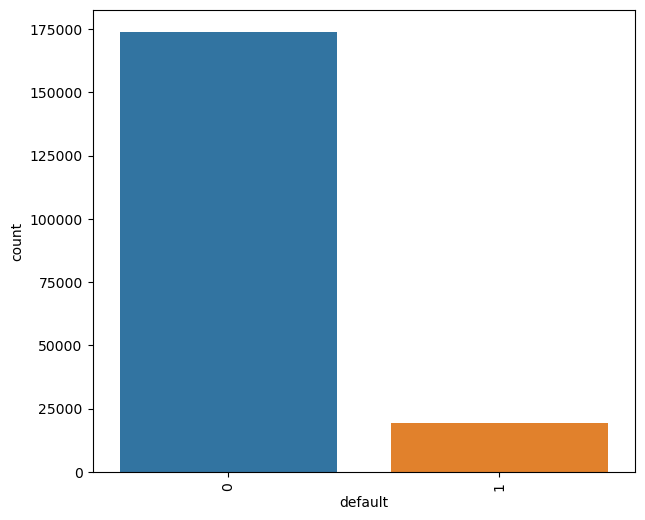

Класс 0: 173948 || Класс 1: 19226
Отношение классов  11.05%


In [43]:
# распределение таргета

plt.figure(figsize=(7, 6))
sns.countplot(x='default', data=df)
plt.xticks(rotation=90)
plt.show()

print(f'Класс 0: {df.default.value_counts()[0]} || Класс 1: {df.default.value_counts()[1]}')
print(f'Отношение классов {df.default.value_counts()[1]/df.default.value_counts()[0]*100: .2f}%')

## 1.3 Выбросы

In [44]:
def outliers(col):
    Q25 = np.quantile(col, .25) 
    Q75 = np.quantile(col, .75) 
    IQR = Q75 - Q25
    return np.where((col < (Q25 - IQR * 1.5)) | (col > (Q75 + IQR * 1.5)), col.mean(), col)


# применим функцию, которая заменяет значения в колонке на среднее, 
# если они больше 75 квантиля или меньше 25 (то есть выбросы)
for col in ['credit_limit', 'max_delq_balance', 'interest_rate']:
    df[col] =  outliers(df[col])

In [45]:
import copy

data_clean = copy.deepcopy(df)

## 1.4 Выбор признаков

In [46]:
%%time

'Определим переменные, которые сильнее всего влияют на default и их оптимальное количество'

y = data_clean.default
x = data_clean.drop('default', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25)


log = Pipeline(steps=[('sc', MinMaxScaler()),
                              ('sl', SelectKBest(score_func=f_classif, k=2)),
                              ('model', LogisticRegression())])

log.fit(x_train, y_train)
                       
param_grid = {'sl__k': np.arange(2, len(data_clean.columns), 1)}     
                
search_log = GridSearchCV(log, 
                          param_grid, 
                          cv=3, 
                          n_jobs=-1, 
                          scoring='roc_auc', 
                          refit=True, 
                          verbose=10)
                
    
search_log.fit(x_train, y_train)

print()
print(f'Оптимальное количество параметров - {search_log.best_estimator_[1]}')
print()

Fitting 3 folds for each of 25 candidates, totalling 75 fits

Оптимальное количество параметров - SelectKBest(k=14)

CPU times: total: 5.19 s
Wall time: 14.1 s


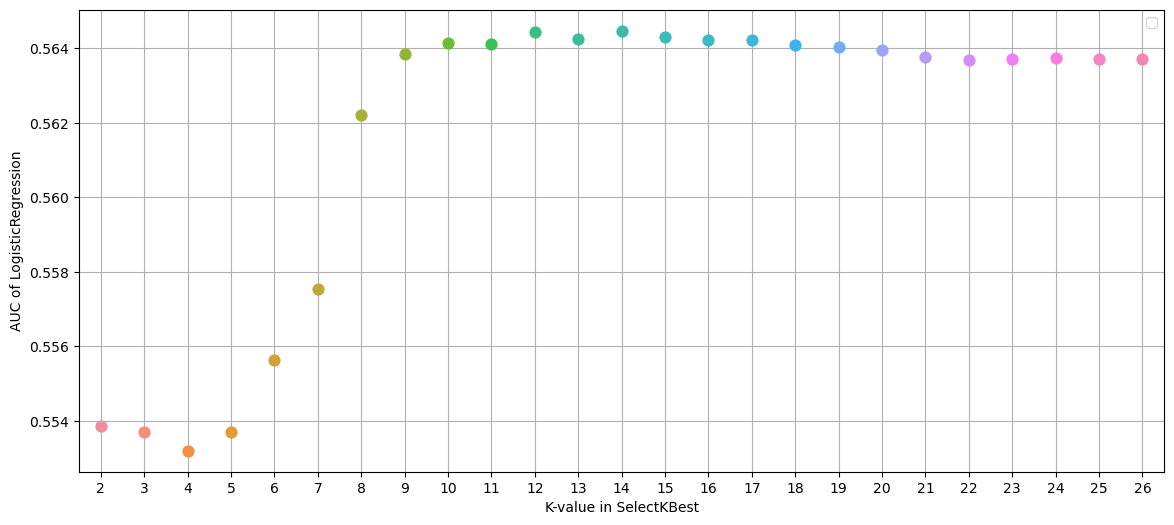

In [47]:
# график точности от количества выбранных факторов
plt.subplots(figsize=(14, 6))

sns.pointplot(x=search_log.cv_results_['param_sl__k'], 
              y=search_log.cv_results_['mean_test_score'],
              hue=search_log.cv_results_['param_sl__k'])

plt.legend(np.arange(2, len(data_clean.columns), 2), 'upper')
plt.xlabel('K-value in SelectKBest')
plt.ylabel('AUC of LogisticRegression')
plt.grid(True)
plt.show()

In [48]:
# выбираем оптимальное количество колонок
select = SelectKBest(score_func=f_classif, k=14)
best = select.fit_transform(x, y)

columns_imp=x.columns[select.get_support()].to_list()
columns_imp

['bureau_cd',
 'type',
 'status',
 'credit_limit',
 'ttl_delq_5',
 'ttl_delq_30',
 'ttl_delq_60_89',
 'ttl_delq_90_plus',
 'max_delq_balance',
 'interest_rate',
 'relationship',
 'bki_request_date_day',
 'bki_request_date_dayWeek',
 'open_date_month']

In [49]:
# нормируем данные
for ind, val in enumerate(data_clean[columns_imp]):
    data_clean[val] = np.log1p(data_clean[val])

# 2. AutoML

In [ ]:
# !pip uninstall scikit-learn -y
# !pip uninstall numpy -y
# !pip install scikit-learn==0.23.2
# !pip install numpy==1.20
# !pip install pycaret

# import pycaret
# from pycaret.classification import *
# from pycaret.utils import enable_colab
# enable_colab()

In [ ]:
# import h2o
# from h2o.automl import H2OAutoML

Воспользуемся библиотекой LightAutoML для нахождения предварительной оценки по моделям.
В данном случае, не используется библиотека PyCaret, которая была в прошлый раз, так как не показывает высокую производительность на больших датасетах

In [3]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [ ]:
# Считывание датасета, небольшая очистка, удаление столбцов с id
df_auto = pd.read_csv('preprocessed_df.csv', sep=';')

print(('df shape - {}'.format(df_auto.shape)))


xx = df_auto.drop('default', axis=1)
yy = df_auto.default

imbalance_auto = SMOTETomek(sampling_strategy='auto', n_jobs=6)
x_imb_auto, y_imb_auto = imbalance_auto.fit_resample(xx, yy)

x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(x_imb_auto, y_imb_auto,
                                                    stratify=y_imb_auto, test_size=0.25)

x_train_auto['default'] = y_train_auto
x_train_auto.shape, y_train_auto.shape, x_test_auto.shape, y_test_auto.shape

df shape - (35031, 59)


((43879, 59), (43879,), (14627, 58), (14627,))

In [ ]:
# настройка модели

roles = {
    'target': 'default',
}

automl = TabularAutoML(
    task=Task('binary', metric = 'auc'),
    timeout=60*3,
    cpu_limit=6,
    reader_params={'n_jobs': 6, 'cv': 5, 'random_state': 101},
    general_params = {'use_algos': [['linear_l2', 'lgb', 'cb', 'lgb_tuned']]},
)

rd = ReportDeco('TabReport2')
automl_rd = rd(automl)

models = automl_rd.fit_predict(x_train_auto, roles=roles, verbose=1)

[12:22:18] Stdout logging level is INFO.
[12:22:18] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[12:22:18] Task: binary

[12:22:18] Start automl preset with listed constraints:
[12:22:18] - time: 180.00 seconds
[12:22:18] - CPU: 6 cores
[12:22:18] - memory: 16 GB

[12:22:18] Train data shape: (43879, 59)

[12:22:22] Layer 1 train process start. Time left 175.67 secs
[12:22:24] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:22:35] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9357531706272837
[12:22:35] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:22:35] Time left 162.61 secs

[12:22:38] Selector_LightGBM fitting and predicting completed
[12:22:41] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:22:56] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.951811684033333
[12:22:56] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:22:56] Start hyperparameters optimization for Lvl_0

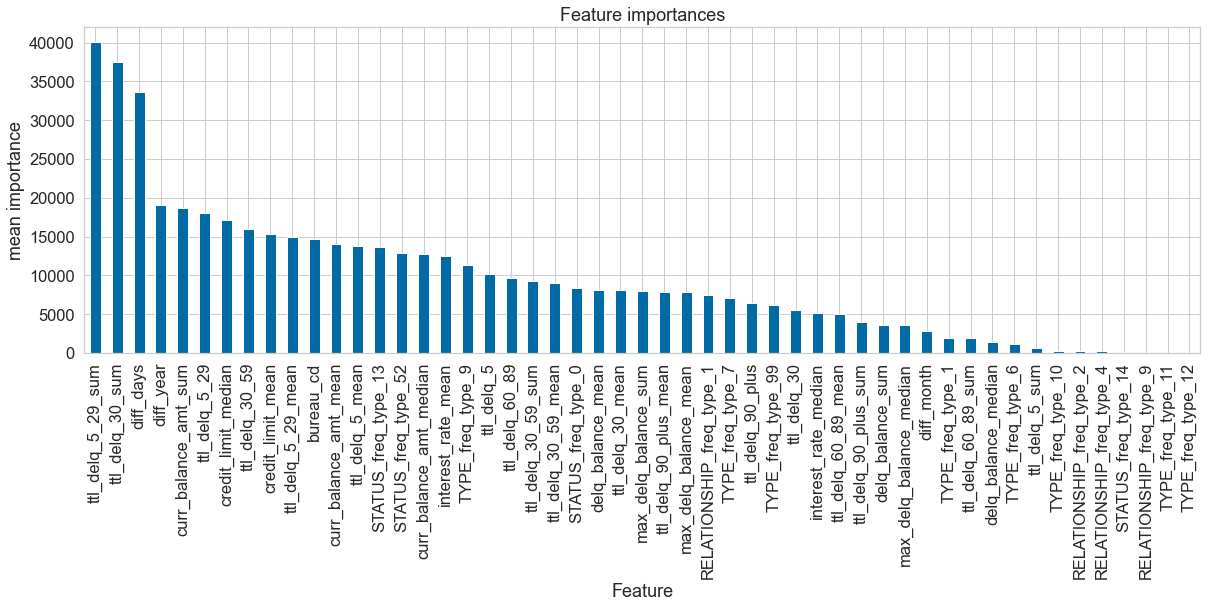

In [ ]:
# feature importances
plt.style.use('tableau-colorblind10')
imps = automl_rd.model.get_feature_scores()
ax = imps.set_index('Feature')['Importance'].plot.bar(figsize=(20, 6))
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')
plt.show()

In [ ]:
imps.head(10) # top 10 by importance

,Feature,Importance
0,ttl_delq_5_29_sum,40052.675446
1,ttl_delq_30_sum,37466.173610
2,diff_days,33624.765519
3,diff_year,19009.337200
4,curr_balance_amt_sum,18723.371205
5,ttl_delq_5_29,17993.110756
6,credit_limit_median,17150.332214
7,ttl_delq_30_59,15954.858116
8,credit_limit_mean,15277.297608
9,ttl_delq_5_29_mean,14926.933203


In [ ]:
preds = automl.predict(x_test_auto)

print(f'AUC score on train: {roc_auc_score(y_train_auto.values, models.data[:, 0])}')
print(f'GINI score on train: {roc_auc_score(y_train_auto.values, models.data[:, 0])*2-1}')
print()
print(f'AUC score on test: {roc_auc_score(y_test_auto.values, preds.data[:, 0])}')
print(f'GINI score on test: {roc_auc_score(y_test_auto.values, preds.data[:, 0])*2-1}')

AUC score on train: 0.953295368200625
GINI score on train: 0.90659073640125

AUC score on test: 0.9534124859812471
GINI score on test: 0.9068249719624941


In [ ]:
# финальная модель automl
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.30768 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.69232 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


In [ ]:
# было обучено 2 модели - с исправлением имбаланса классов и без
# 0.71 AUC с имбалансным распределением таргета
# 0.95 AUC cо сбалансированным распределением

# 3. Модели

In [50]:
# функция для оценки моделей

def get_report(pipe, x_test, y_test):
    
    predictions = pipe.predict(x_test)
    predictions = np.round(predictions.ravel(), 0)

    roc_auc_scores_pipe = roc_auc_score(y_test, pipe.predict_proba(x_test)[:, 1])
    gini = (2 * roc_auc_scores_pipe) - 1
    
    print('y_test - ', Counter(y_test))
    print('predictions - ', Counter(predictions))
    print()
    print(f'roc_auc_score - {round(roc_auc_scores_pipe, 4)}')
    print('Gini - ', round(gini, 4))
    print()
    print((classification_report(y_test, predictions)))

In [51]:
%%time

data_clean=data_clean[columns_imp+['default']]
data_clean.dropna(axis=0, inplace=True)
data_clean.drop_duplicates(inplace=True)

y = data_clean.default
x = data_clean.drop('default', axis=1)


# для улучшения качества моделей применим метод SMOTETomek,
# который создает новые строки с таргетом 1 (у нас соотношение 1 к 9)
from imblearn.over_sampling import SMOTE
imbalance = SMOTETomek(sampling_strategy='auto', n_jobs=6)
x_imb, y_imb = imbalance.fit_resample(x, y)



x_imb.shape, y_imb.shape

CPU times: total: 3min 46s
Wall time: 43.9 s


((324476, 14), (324476,))

In [180]:
print(
'Количесво классов после SMOTETomek:', Counter(y_imb)
)

Количесво классов после SMOTETomek: Counter({0: 162238, 1: 162238})


In [52]:
# делим выборку на train/ test
x_train, x_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, test_size=0.25, )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((243357, 14), (243357,), (81119, 14), (81119,))

In [53]:
# делим выборку на test/ validation
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=0.1)
x_test.shape, y_test.shape, x_val.shape, y_val.shape

((73007, 14), (73007,), (8112, 14), (8112,))

## 3.1 LogisticRegression

In [ ]:
# для улучшения показателей линейной модели, признаки должны быть линейно зависимы с таргетом
# выделим наиболее значимые признаки с помощью корреляции

In [74]:
corr = pd.concat([x_train, y_train], axis=1).corr()

<Axes: >

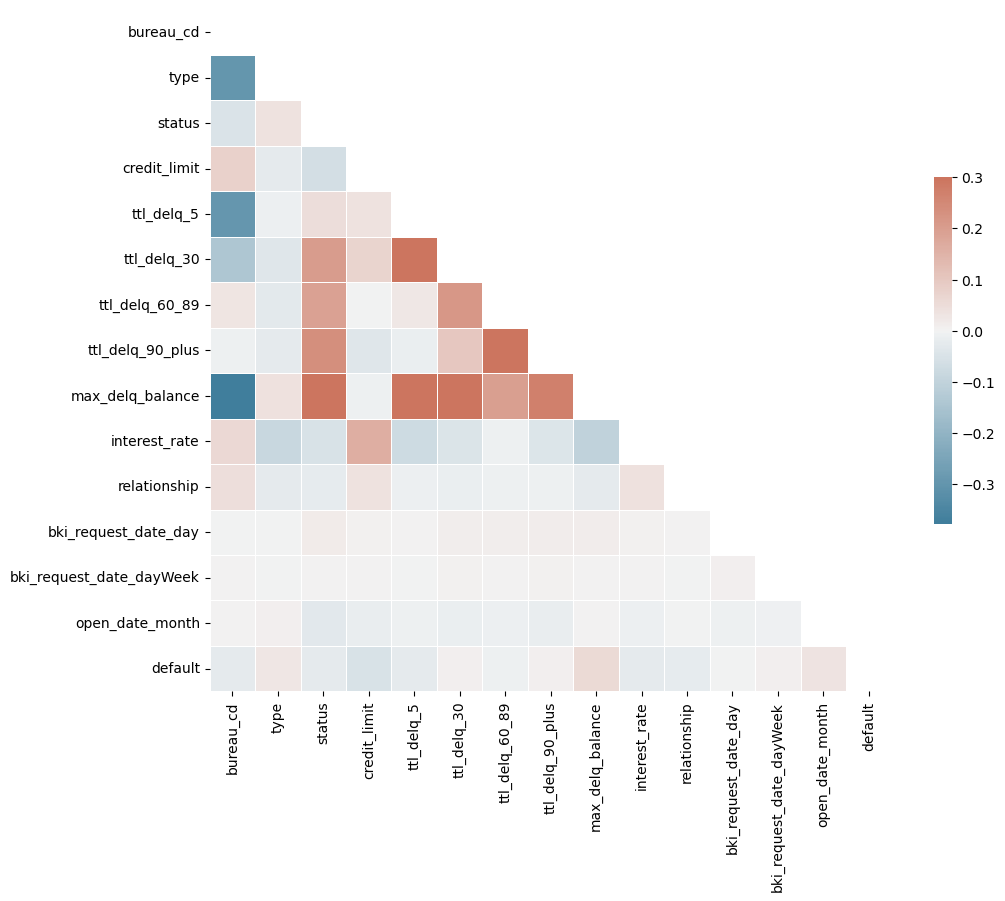

In [75]:
corr = pd.concat([x_train, y_train], axis=1).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})

In [92]:
max_iter = range(100, 300, 50)
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C = np.arange(0, 1, 0.1)

random_grid ={
    'model__max_iter' : max_iter,
    'model__warm_start' : warm_start,
    'model__solver' : solver,
    'model__C' : C,
}


estimator = Pipeline(steps=[('sc', MinMaxScaler()), 
                              ('model', LogisticRegression() )])

random_estimator = RandomizedSearchCV(estimator = estimator,
                                   param_distributions = random_grid,
                                   n_iter = 20,
                                   scoring = 'f1',
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1881,
                                  )

random_estimator.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('sc', MinMaxScaler()),
                                             ('model', LogisticRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'model__max_iter': range(100, 300, 50),
                                        'model__solver': ['lbfgs', 'newton-cg',
                                                          'liblinear'],
                                        'model__warm_start': [True, False]},
                   random_state=1881, scoring='f1', verbose=1)

In [93]:
print(random_estimator.best_params_, '\n')

best_estimator = random_estimator.best_estimator_
best_estimator.fit(x_train, y_train)

get_report(pipe=best_estimator, x_test=x_test, y_test=y_test)
print()

{'model__warm_start': False, 'model__solver': 'lbfgs', 'model__max_iter': 200, 'model__C': 0.4} 

y_test -  Counter({1: 36504, 0: 36503})
predictions -  Counter({0: 39525, 1: 33482})

roc_auc_score - 0.5793
Gini -  0.1586

              precision    recall  f1-score   support

           0       0.55      0.60      0.58     36503
           1       0.56      0.52      0.54     36504

    accuracy                           0.56     73007
   macro avg       0.56      0.56      0.56     73007
weighted avg       0.56      0.56      0.56     73007




Text(0, 0.5, 'Mean importance')

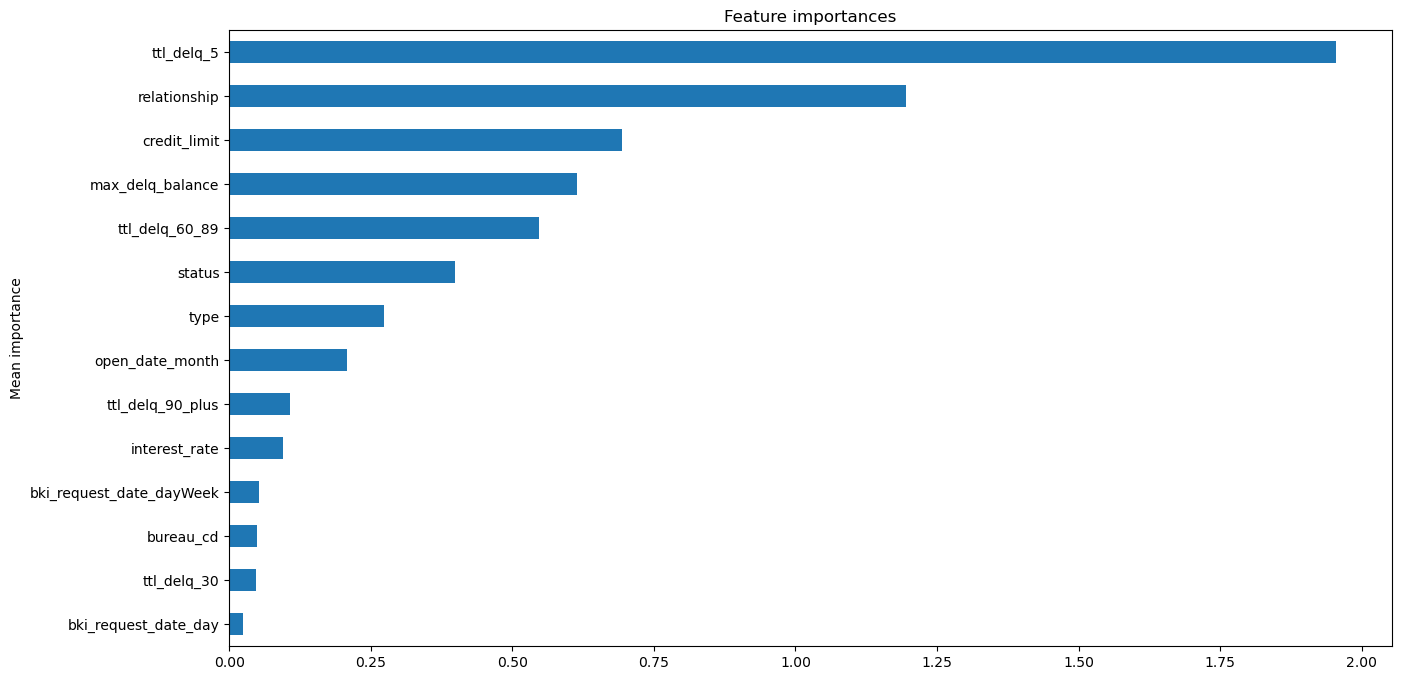

In [95]:
# plt.style.use('tableau-colorblind10')
log_importances = pd.Series(abs(pipe_logreg[-1].coef_[0]), 
                            index=x_train.columns).sort_values(0, ascending=True)[:25]

fig, ax = plt.subplots(figsize=(15,8))
log_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean importance')

In [96]:
feat_imp = pd.DataFrame(log_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
ttl_delq_5,1.955035,Количество просрочек до 5 дней
relationship,1.194504,Тип отношения к договору
credit_limit,0.694176,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
max_delq_balance,0.615096,Максимальный объем просроченной задолженности....
ttl_delq_60_89,0.547859,Количество просрочек от 60 до 89 дней
status,0.398073,Статус договора
type,0.274258,Код типа договора
open_date_month,0.208038,месяц открытия договора
ttl_delq_90_plus,0.107665,Количество просрочек 90+ дней
interest_rate,0.095356,Процентная ставка по кредиту


In [ ]:
# в обучающей выборке нет коррелируемых с таргетом признаков, это значит,
# что модель не сможет достичь наилучшего качества

## 3.2 LinearRegression

In [98]:
pipe_linreg = Pipeline(steps=[('scaler', MinMaxScaler()), 
                              ('logistic', LinearRegression(positive=True, 
                                                            fit_intercept=True))])

pipe_linreg.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LinearRegression(positive=True))])

In [101]:
predictions = pipe_linreg.predict(x_test)
predictions = np.round(predictions.ravel(), 0)
diff = predictions - y_test

print('MSE:', np.mean(diff**2))
print('MAE:', np.mean(abs(diff)))
print('RMSE:', np.sqrt(np.mean(diff**2)))
print()

get_report(pipe=pipe_logreg, x_test=x_test, y_test=y_test)
print()

MSE: 0.472379360883203
MAE: 0.472379360883203
RMSE: 0.6872985965962705

y_test -  Counter({1: 36504, 0: 36503})
predictions -  Counter({0: 39522, 1: 33485})

roc_auc_score - 0.5793
Gini -  0.1587

              precision    recall  f1-score   support

           0       0.55      0.60      0.58     36503
           1       0.56      0.52      0.54     36504

    accuracy                           0.56     73007
   macro avg       0.56      0.56      0.56     73007
weighted avg       0.56      0.56      0.56     73007




Text(0, 0.5, 'mean importance')

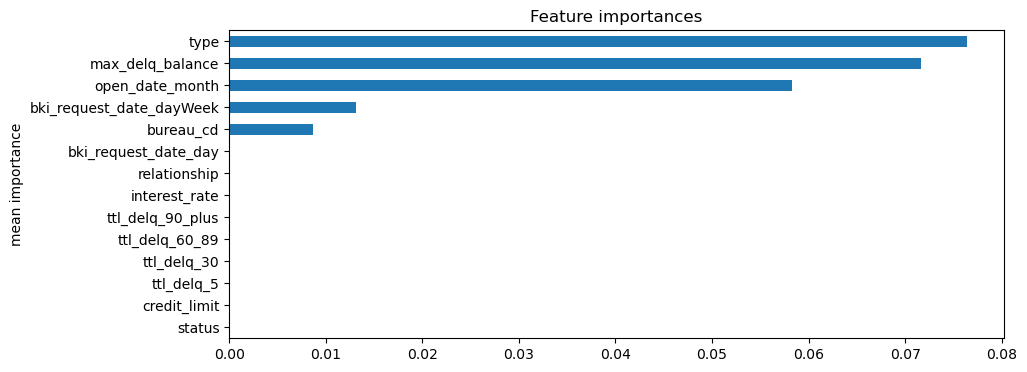

In [104]:
# plt.style.use('tableau-colorblind10')
log_importances = pd.Series(abs(pipe_linreg[-1].coef_), index=x_test.columns) \
                                 .sort_values(0, ascending=True)

fig, ax = plt.subplots(figsize=(10, 4))
log_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')

In [105]:
feat_imp = pd.DataFrame(log_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
type,0.076423,Код типа договора
max_delq_balance,0.071588,Максимальный объем просроченной задолженности....
open_date_month,0.058250,месяц открытия договора
bki_request_date_dayWeek,0.013121,"день недели, в который был сделан запрос в бюро"
bureau_cd,0.008719,"Код бюро, из которого получен счет"
status,0.000000,Статус договора
credit_limit,0.000000,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
ttl_delq_5,0.000000,Количество просрочек до 5 дней
ttl_delq_30,0.000000,Количество просрочек до 30 дней
ttl_delq_60_89,0.000000,Количество просрочек от 60 до 89 дней


In [ ]:
# Аналогично c LinearRegression

# Если оценивать результаты по MSE или MAE, то ошибка очень большая
# при выборе 0 или 1, ошибка состовляет +-0.47 - очень много

# Для улучшения нужны коррелируемые с таргетом признаки

## 3.3 RandomForestClassifier

In [ ]:
# from imblearn.ensemble import BalancedRandomForestClassifier

In [54]:
pipe_rforest = Pipeline(steps=[
            ('m', RandomForestClassifier(verbose=1, 
                                         n_jobs=-1,
                                         criterion='gini',
                                         n_estimators=100,
#                                          max_depth=12,
                                        #  min_samples_leaf=6,
                                        #  max_samples=500,
                                        #  class_weight={0: 1, 1: 10},
                                         class_weight='balanced_subsample'
                                         ))
])

pipe_rforest.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished


Pipeline(steps=[('m',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_jobs=-1, verbose=1))])

In [55]:
get_report(pipe=pipe_rforest, x_test=x_test, y_test=y_test)
print()

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s


y_test -  Counter({1: 36504, 0: 36503})
predictions -  Counter({0: 38851, 1: 34156})

roc_auc_score - 0.9734
Gini -  0.9468

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     36503
           1       0.96      0.90      0.93     36504

    accuracy                           0.93     73007
   macro avg       0.93      0.93      0.93     73007
weighted avg       0.93      0.93      0.93     73007




[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.3s finished


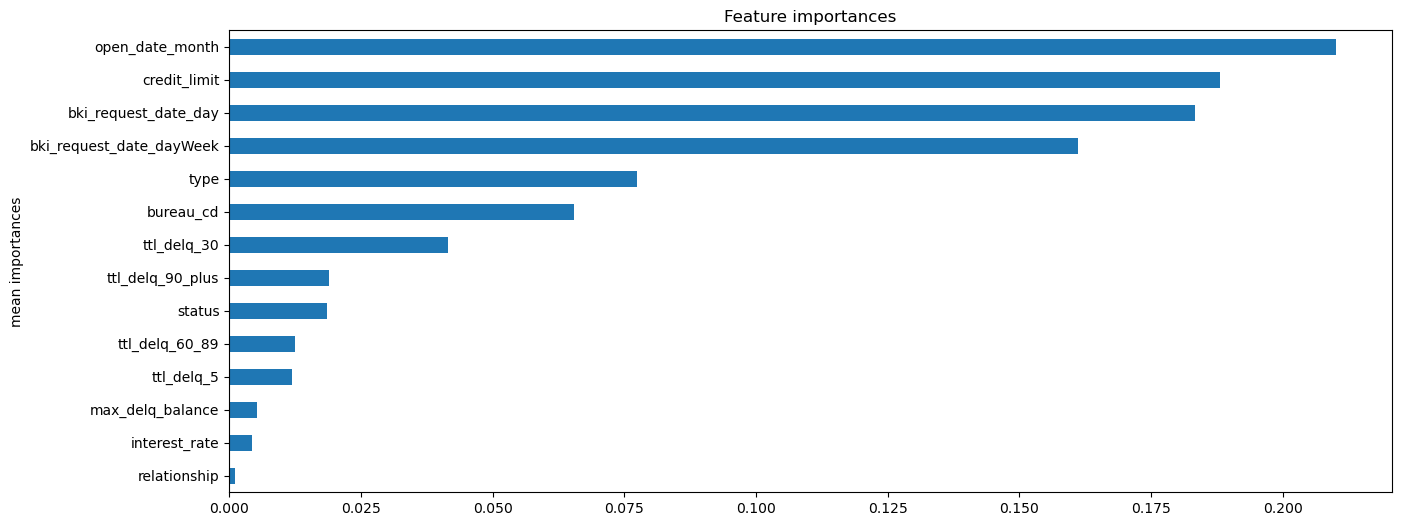

In [56]:
importances = pipe_rforest[-1].feature_importances_

forest_importances = pd.Series(importances, index=x_train.columns).sort_values(0, ascending=True)[:25]

fig, ax = plt.subplots(figsize=(15,6))
forest_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importances')
plt.show()

In [57]:
feat_imp = pd.DataFrame(forest_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
open_date_month,0.210132,месяц открытия договора
credit_limit,0.187994,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
bki_request_date_day,0.183318,"день, в который был сделан запрос в бюро"
bki_request_date_dayWeek,0.161200,"день недели, в который был сделан запрос в бюро"
type,0.077463,Код типа договора
bureau_cd,0.065517,"Код бюро, из которого получен счет"
ttl_delq_30,0.041581,Количество просрочек до 30 дней
ttl_delq_90_plus,0.019043,Количество просрочек 90+ дней
status,0.018609,Статус договора
ttl_delq_60_89,0.012455,Количество просрочек от 60 до 89 дней


In [123]:
%%time
cv_pipe_rforest = cross_val_predict(pipe_rforest,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                    X=x_test,
                                    y=y_test,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   15.3s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished


CPU times: total: 93.8 ms
Wall time: 16 s


In [124]:
print(f'auc score = {roc_auc_score(y_test, cv_pipe_rforest[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_test, cv_pipe_rforest[:, 1]) - 1) :.5f}')

auc score = 0.96338
Gini      = 0.92676


In [ ]:
# модель RandomForestClassifier показала высокие результаты по AUC - 0.9612,
# оценка через кросс-валидацию составила 0.95154

# Высокий результат

# Также, модель обучалась с PolynomialFeatures.
# несмотря на это, модель быстро обучается (5 секунд в среднем) и быстро дает прогнозы

## 3.4 LGBMClassifier

In [ ]:
# при помощи optuna посмотрим, можно ли достичь более высокую оценку, 
# чем у RandomForestClassifier

In [58]:
# функция, которую будем минимизировать

# мы задаем параметры и считаем logloss на тестовой выборке
# далее optuna будет минимизировать это значения (то есть повышать качество по AUC)
# также, внутри идет кросс-валидация с 5 фолдами
# для ускорения поиска используется callbcack для пропуска неудачных параметров

def objective(trial, x, y):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 700, 1500, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 50, step=1),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.9),
        'num_leaves': trial.suggest_int('num_leaves', 70, 150, step=10),
#         'num_leaves': trial.suggest_categorical('num_leaves', [30, 50, 80, 90]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 30.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 30.0),
        }
    
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1881)
    train_scores = []
    test_scores = []
    losses = []
   
    for idx, (train_idx, test_idx) in enumerate( cv.split(x, y) ):
        x_tr, x_val = x.iloc[train_idx], x.iloc[test_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        callback = optuna.integration.LightGBMPruningCallback(trial, 'binary_logloss')
        model = LGBMClassifier(n_jobs=-1, objective='binary', **params)
        
        model.fit(x_tr, 
                  y_tr, 
                  eval_set=[(x_val, y_val)],
                  eval_metric=['logloss'],
                  early_stopping_rounds=10, 
                  verbose=0,
                  callbacks=[callback]
                 )
    
        train_score_auc = roc_auc_score(y_tr, model.predict_proba(x_tr)[:, 1])
        train_score_gini = 2 * train_score_auc - 1
        
        test_score_auc = roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])
        test_score_gini = 2 * test_score_auc - 1
        
        train_loss = log_loss(y_tr, model.predict_proba(x_tr))
        test_loss = log_loss(y_val, model.predict_proba(x_val))
        
        
        train_scores.append(train_score_auc)
        test_scores.append(test_score_auc)
        losses.append(test_loss)
        
    train_score = np.round(np.mean(train_scores), 6)
    test_score = np.round(np.mean(test_scores), 6)    
    loss = np.round(np.mean(losses), 6)
    
    
    print(f'TRAIN AUC : {train_score} || VAL AUC : {test_score} || VAL LOSS : {loss}')
    
    return loss

In [59]:
study = optuna.create_study(study_name='lightgbm_model', directions=['minimize'])
                                            
func = lambda trial: objective(trial=trial, x=x_train, y=y_train)

study.optimize(func, 
               n_trials=20, 
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-04-05 15:29:05,346] A new study created in memory with name: lightgbm_model


  0%|          | 0/20 [00:00<?, ?it/s]

TRAIN AUC : 0.965765 || VAL AUC : 0.955234 || VAL LOSS : 0.208723
[I 2023-04-05 15:29:16,395] Trial 2 finished with value: 0.208723 and parameters: {'n_estimators': 700, 'max_depth': 36, 'learning_rate': 0.7612256838325787, 'num_leaves': 70, 'reg_alpha': 0.028055649726424152, 'reg_lambda': 7.508357528272445e-08}. Best is trial 2 with value: 0.208723.
TRAIN AUC : 0.972175 || VAL AUC : 0.956616 || VAL LOSS : 0.207101
[I 2023-04-05 15:29:38,065] Trial 6 finished with value: 0.207101 and parameters: {'n_estimators': 700, 'max_depth': 36, 'learning_rate': 0.8839848088558092, 'num_leaves': 150, 'reg_alpha': 3.7057708666487325e-08, 'reg_lambda': 0.1854279990957604}. Best is trial 6 with value: 0.207101.
TRAIN AUC : 0.986975 || VAL AUC : 0.960887 || VAL LOSS : 0.198169
[I 2023-04-05 15:29:41,212] Trial 3 finished with value: 0.198169 and parameters: {'n_estimators': 1300, 'max_depth': 24, 'learning_rate': 0.5857154060967771, 'num_leaves': 150, 'reg_alpha': 0.00031898370725303365, 'reg_lambda':

In [60]:
print('Best parameters:', study.best_params)
print()
print('Best log_loss value on test:', study.best_value)
print()
print()

model = LGBMClassifier(**study.best_params, n_jobs=-1)
model.fit(x_train, y_train, verbose=1)

Best parameters: {'n_estimators': 950, 'max_depth': 47, 'learning_rate': 0.07083541507396161, 'num_leaves': 130, 'reg_alpha': 0.049729498343960545, 'reg_lambda': 4.836348705358589e-05}

Best log_loss value on test: 0.177275




LGBMClassifier(learning_rate=0.07083541507396161, max_depth=47,
               n_estimators=950, num_leaves=130, reg_alpha=0.049729498343960545,
               reg_lambda=4.836348705358589e-05)

In [61]:
print(f'auc score TEST  = {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.5f}')
print(f'Gini TEST      = { (2 * roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]) - 1) :.5f}')

auc score TEST  = 0.97039
Gini TEST      = 0.94078


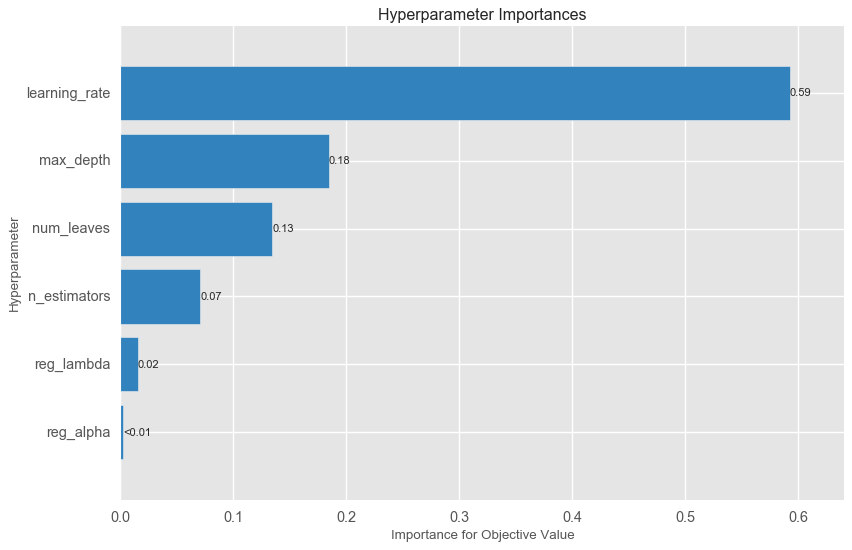

In [ ]:
plt.style.use('tableau-colorblind10')
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show() # график, от каких параметров больше всего зависит качество модели

Text(0, 0.5, 'mean importance')

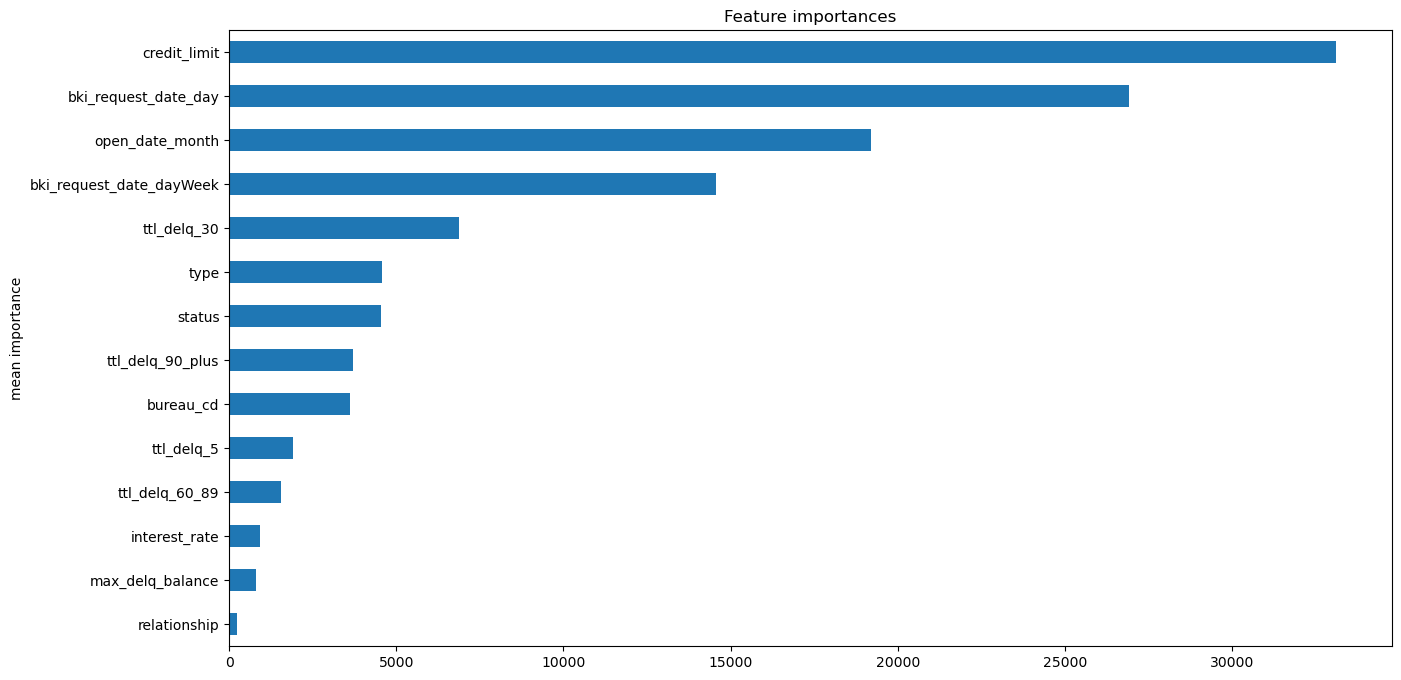

In [62]:
# plt.style.use('tableau-colorblind10')
importances_lgbm = model.feature_importances_
lgbm_importances = pd.Series(importances_lgbm, index=x_train.columns).sort_values(0, ascending=True)[:25]

fig, ax = plt.subplots(figsize=(15,8))
lgbm_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')

In [63]:
feat_imp = pd.DataFrame(lgbm_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
credit_limit,33117,Кредитный лимит. Сумма в рублях по курсу ЦБ РФ
bki_request_date_day,26926,"день, в который был сделан запрос в бюро"
open_date_month,19212,месяц открытия договора
bki_request_date_dayWeek,14559,"день недели, в который был сделан запрос в бюро"
ttl_delq_30,6879,Количество просрочек до 30 дней
type,4559,Код типа договора
status,4554,Статус договора
ttl_delq_90_plus,3719,Количество просрочек 90+ дней
bureau_cd,3606,"Код бюро, из которого получен счет"
ttl_delq_5,1902,Количество просрочек до 5 дней


In [ ]:
# получились тоже высокии результаты, как и у RandomForestClassifier
# результаты примерно такие же - 0.96462

## 3.5 XGBClassifier

In [64]:
pipe_xgb_cls = Pipeline(steps=[('scaler', MinMaxScaler()), 
                               ('model', XGBClassifier(tree_method='gpu_hist',
                                                       objective='binary:logistic',
                                                       learning_rate=0.5,
                                                       n_estimators=50,
                                                       reg_lambda=25,
                                                       max_depth=30))])

pipe_xgb_cls.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=30, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [65]:
get_report(pipe=pipe_xgb_cls, x_test=x_test, y_test=y_test)
print()

y_test -  Counter({1: 36504, 0: 36503})
predictions -  Counter({0: 39908, 1: 33099})

roc_auc_score - 0.9728
Gini -  0.9455

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     36503
           1       0.98      0.89      0.93     36504

    accuracy                           0.94     73007
   macro avg       0.94      0.94      0.94     73007
weighted avg       0.94      0.94      0.94     73007




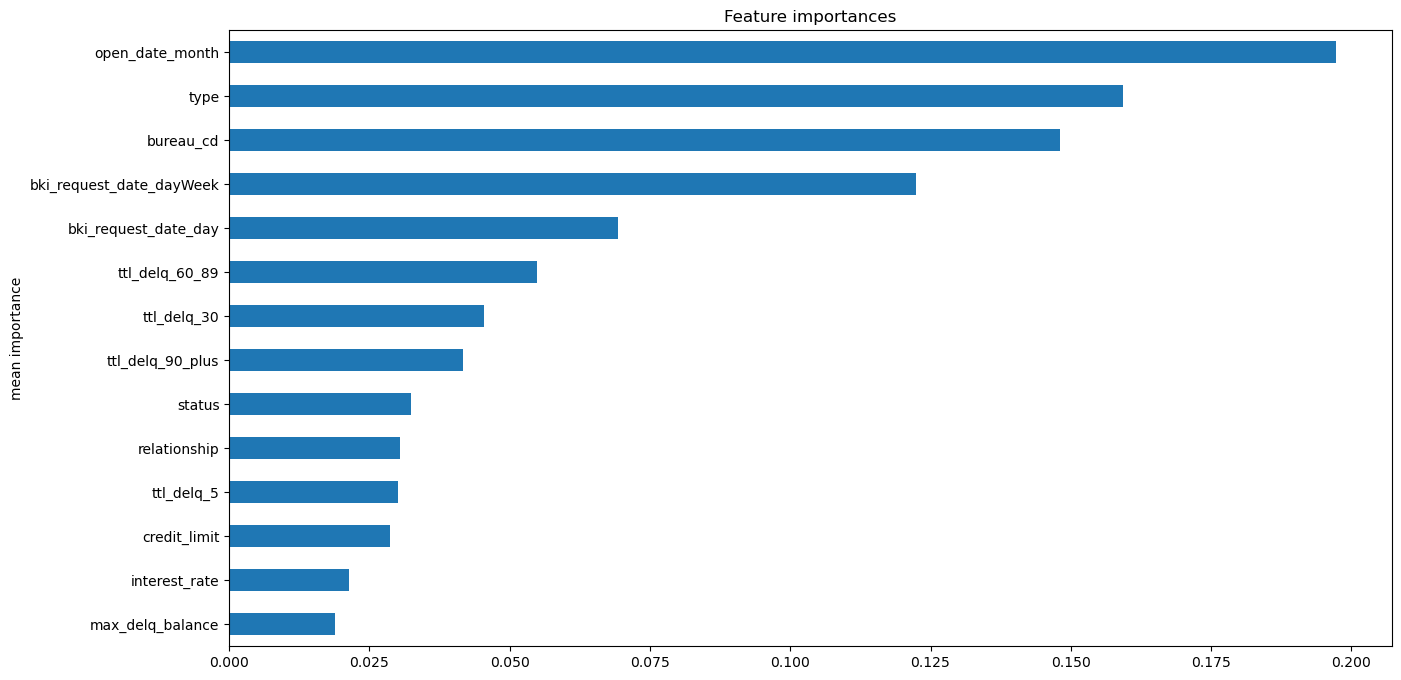

In [66]:
importances = pipe_xgb_cls[-1].feature_importances_

xgb_importances = pd.Series(importances, index=x_train.columns).sort_values(0, ascending=True)

# plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(figsize=(15,8))
xgb_importances.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')
plt.show()

In [67]:
feat_imp = pd.DataFrame(xgb_importances).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
open_date_month,0.197314,месяц открытия договора
type,0.159297,Код типа договора
bureau_cd,0.148140,"Код бюро, из которого получен счет"
bki_request_date_dayWeek,0.122457,"день недели, в который был сделан запрос в бюро"
bki_request_date_day,0.069233,"день, в который был сделан запрос в бюро"
ttl_delq_60_89,0.054903,Количество просрочек от 60 до 89 дней
ttl_delq_30,0.045413,Количество просрочек до 30 дней
ttl_delq_90_plus,0.041595,Количество просрочек 90+ дней
status,0.032339,Статус договора
relationship,0.030432,Тип отношения к договору


In [173]:
cv_xgb_cls = cross_val_predict(pipe_xgb_cls,
                                    cv=StratifiedKFold(n_splits=5, shuffle=True),
                                    X=x_test,
                                    y=y_test,
                                    verbose=10,
                                    n_jobs=-1,
                                    method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.1s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


In [174]:
print(f'auc score = {roc_auc_score(y_test, cv_xgb_cls[:, 1]):.5f}')
print(f'Gini      = { (2 * roc_auc_score(y_test, cv_xgb_cls[:, 1]) - 1) :.5f}')

auc score = 0.95888
Gini      = 0.91776


In [ ]:
# Аналогично RandomForestClassifier и LGBMClassifier - AUC=0.9692
# проверка через кросс-валидацию уменьшило AUC до 0.95888

## 3.6 CatBoost

In [68]:
from catboost import CatBoostClassifier, cv, Pool, MetricVisualizer
from catboost.utils import select_threshold, get_roc_curve, get_fpr_curve, get_fnr_curve
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures

In [69]:
model_catboost_cls = CatBoostClassifier(
    loss_function='Logloss', custom_loss='AUC', eval_metric='AUC',
    learning_rate=0.01, iterations=3500,
    l2_leaf_reg=10, random_strength=101, depth=8,
)

m = model_catboost_cls.fit(x_train, y_train, eval_set=(x_test, y_test),
                       verbose=500, plot=True, early_stopping_rounds=200)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5740346	best: 0.5740346 (0)	total: 181ms	remaining: 10m 32s
500:	test: 0.8053591	best: 0.8054256 (499)	total: 14s	remaining: 1m 23s
1000:	test: 0.8379726	best: 0.8379726 (1000)	total: 27.8s	remaining: 1m 9s
1500:	test: 0.9000069	best: 0.9000069 (1500)	total: 42.1s	remaining: 56.1s
2000:	test: 0.9494474	best: 0.9494474 (2000)	total: 57.1s	remaining: 42.8s
2500:	test: 0.9537863	best: 0.9537863 (2500)	total: 1m 12s	remaining: 28.9s
3000:	test: 0.9555929	best: 0.9555929 (3000)	total: 1m 27s	remaining: 14.6s
3499:	test: 0.9568817	best: 0.9568817 (3499)	total: 1m 42s	remaining: 0us

bestTest = 0.956881656
bestIteration = 3499



In [70]:
print(f'auc score TEST  = {roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val)[:, 1]):.5f}')
print(f'Gini TEST       = { (2 * roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val)[:, 1]) - 1) :.5f}')

# test выборка учавствует в обучении, поэтому проверяем результаты на val-выборке
# результат финальный, такой же будет в пункте 4.1

auc score TEST  = 0.95662
Gini TEST       = 0.91324


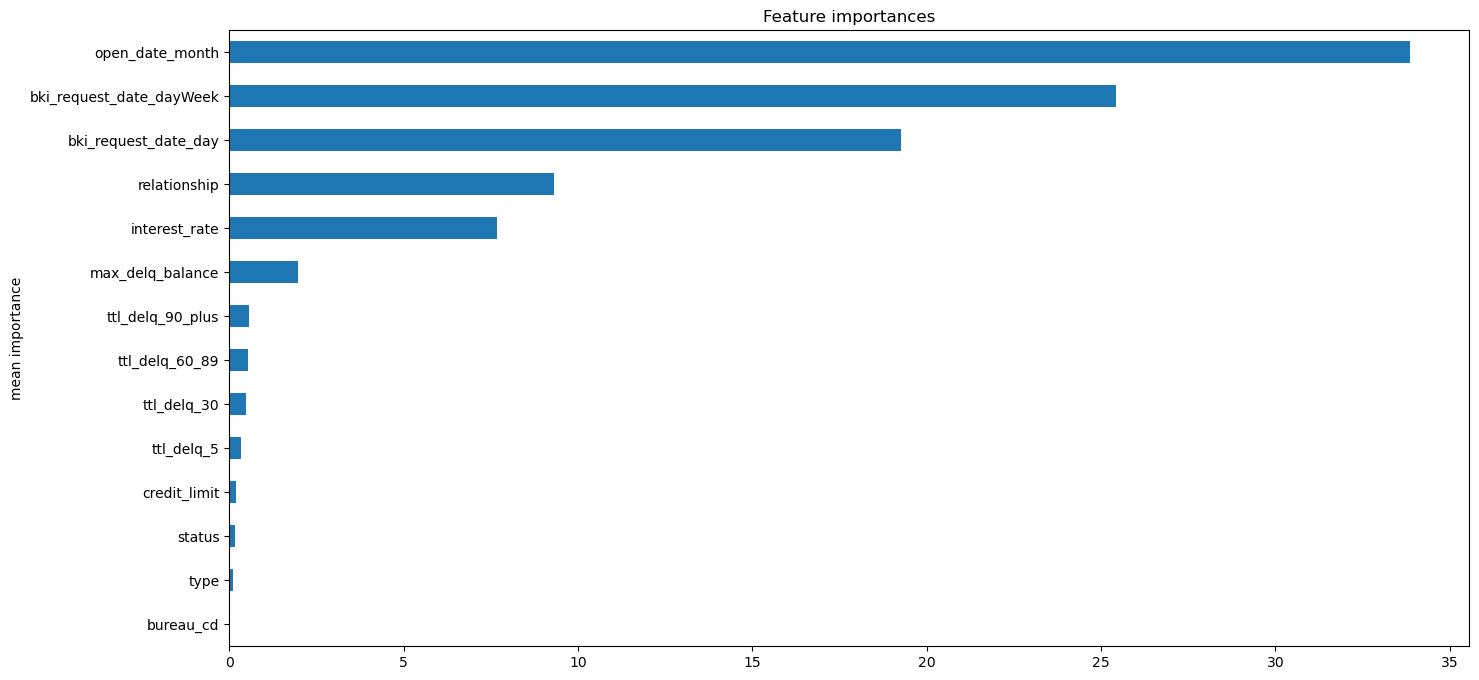

In [72]:
# plt.style.use('tableau-colorblind10')
cat_features = pd.DataFrame(model_catboost_cls.get_feature_importance(prettified=True)) \
                                              .sort_values('Importances', ascending=True)

skl_iris_imp = pd.Series(cat_features.Importances.values,
                         x_train.columns)

fig, ax = plt.subplots(figsize=(16, 8))
skl_iris_imp.plot.barh(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('mean importance')
plt.show()

In [73]:
feat_imp = pd.DataFrame(skl_iris_imp).sort_values(0, ascending=False)
feat_imp['Description'] = [desc_param.get(param.upper()) for param in feat_imp.index]
feat_imp

,0,Description
open_date_month,33.859316,месяц открытия договора
bki_request_date_dayWeek,25.438187,"день недели, в который был сделан запрос в бюро"
bki_request_date_day,19.271697,"день, в который был сделан запрос в бюро"
relationship,9.324288,Тип отношения к договору
interest_rate,7.678067,Процентная ставка по кредиту
max_delq_balance,1.973477,Максимальный объем просроченной задолженности....
ttl_delq_90_plus,0.579649,Количество просрочек 90+ дней
ttl_delq_60_89,0.541764,Количество просрочек от 60 до 89 дней
ttl_delq_30,0.487675,Количество просрочек до 30 дней
ttl_delq_5,0.340032,Количество просрочек до 5 дней


In [ ]:
# модель, как и остальные бустинги, показывает хорошее качетсво
# есть небольшое недообучение, но если смотреть по графику AUC - качество достигло максимума - 0.95189
# на train-0.98, на test=0.95 

# у LGBMClassifier, например, почти 1 на train, сильнее недообучение

## 3.7 NN

In [181]:
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# from livelossplot import PlotLossesKeras

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, test_size=0.25, )


x_train_sc = MinMaxScaler().fit_transform(x_train)
x_test_sc = MinMaxScaler().fit_transform(x_test)

x_train_sc.shape, y_train.shape, x_test_sc.shape, y_test.shape

((29845, 34), (29845,), (9949, 34), (9949,))

In [ ]:
# структура модели
model = Sequential()

model.add(Dense(units = 500, input_shape = (x_train_sc.shape[1],), activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

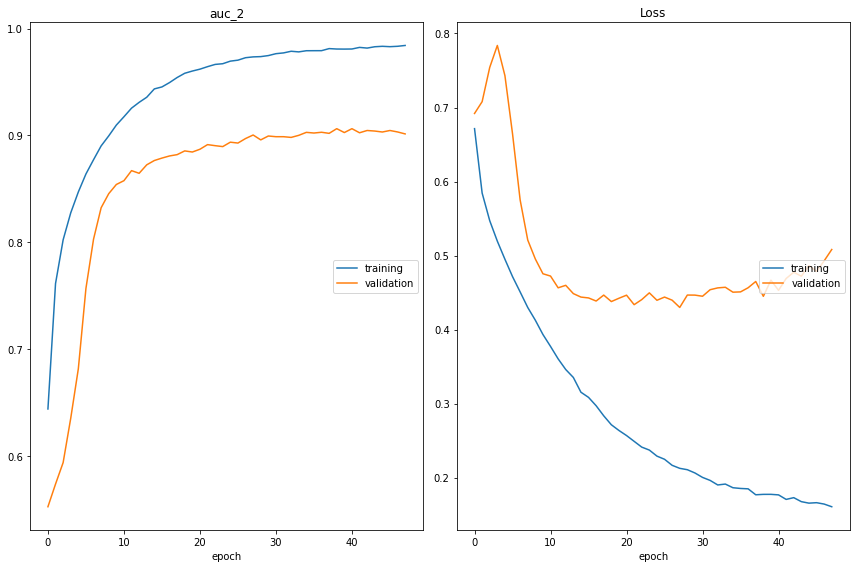

auc_2
	training         	 (min:    0.644, max:    0.984, cur:    0.984)
	validation       	 (min:    0.552, max:    0.906, cur:    0.901)
Loss
	training         	 (min:    0.161, max:    0.671, cur:    0.161)
	validation       	 (min:    0.430, max:    0.784, cur:    0.508)
22422/22422 [==============================] - 1s 44us/sample - loss: 0.1606 - auc_2: 0.9843 - val_loss: 0.5081 - val_auc_2: 0.9015



In [ ]:
cp = ModelCheckpoint('model/', save_best_only=True)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.0008, nesterov=True), metrics=[keras.metrics.AUC()])
# model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=[keras.metrics.AUC()])

model.compile(loss=keras.losses.BinaryCrossentropy(), 
              optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00005), 
              metrics=[keras.metrics.AUC()]
              )

history = model.fit(x_train_sc, 
                    y_train, 
                    validation_split = 0.25, 
                    batch_size=256, 
                    epochs=100, 
                    verbose=1,
                    callbacks=[cp, PlotLossesKeras(), callback])
                                 

print('\n ==============')

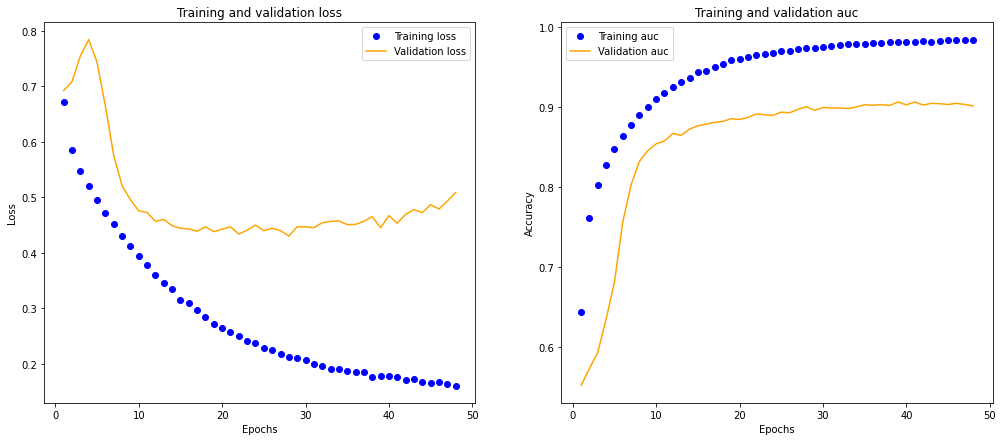


Best auc score: 0.9063808917999268


In [ ]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1) 

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc = history.history[list(history.history.keys())[1]]
val_acc = history.history[list(history.history.keys())[3]]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'orange', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

print()
print(f'Best auc score: {np.max(val_acc)}')

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, auc, roc_curve

model = load_model('model/')

predictions = model.predict(x_test_sc, batch_size=128)
predictions = np.round(predictions.ravel(), 0)

print()
print(f'auc(fpr, tpr): {auc(roc_curve(y_test, predictions)[0], roc_curve(y_test, predictions)[1]):.4f}' )
print()
print(classification_report(y_test, predictions))


auc(fpr, tpr): 0.8233

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      4983
           1       0.81      0.85      0.83      4983

    accuracy                           0.82      9966
   macro avg       0.82      0.82      0.82      9966
weighted avg       0.82      0.82      0.82      9966



In [ ]:
# в целом, результаты схожи с логистической регрессией

# есть недообучение, но по графику AUC видно, что концентрация значений начинает увеличиваться
# это значит, что локальный максимум возможно найден 
# (график похож на AUC CatBoost - тоже выходит в прямую линию)

# 4. Результаты

## 4.1 Таблица результатов

In [112]:
da = [
      ['LogisticRegression',
       roc_auc_score(y_val, pipe_logreg.predict_proba(x_val)[:, 1]),
       2 * roc_auc_score(y_val, pipe_logreg.predict_proba(x_val)[:, 1])-1,
       precision_recall_fscore_support(y_val, np.round(pipe_logreg.predict(x_val), 0), average='weighted')[0],
       precision_recall_fscore_support(y_val, np.round(pipe_logreg.predict(x_val), 0), average='weighted')[1],
       precision_recall_fscore_support(y_val, np.round(pipe_logreg.predict(x_val), 0), average='weighted')[2]],
      
      ['LinearRegression',
       roc_auc_score(y_val, pipe_linreg.predict(x_val)),
       2 * roc_auc_score(y_val, pipe_linreg.predict(x_val))-1,
       precision_recall_fscore_support(y_val, np.round(pipe_linreg.predict(x_val), 0), average='weighted')[0],
       precision_recall_fscore_support(y_val, np.round(pipe_linreg.predict(x_val), 0), average='weighted')[1],
       precision_recall_fscore_support(y_val, np.round(pipe_linreg.predict(x_val), 0), average='weighted')[2]],
      
      ['RandomForestClassifier',
       roc_auc_score(y_val, pipe_rforest.predict_proba(x_val)[:, 1]),
       2 * roc_auc_score(y_val, pipe_rforest.predict_proba(x_val)[:, 1])-1,
       precision_recall_fscore_support(y_val, np.round(pipe_rforest.predict(x_val), 0), average='weighted')[0],
       precision_recall_fscore_support(y_val, np.round(pipe_rforest.predict(x_val), 0), average='weighted')[1],
       precision_recall_fscore_support(y_val, np.round(pipe_rforest.predict(x_val), 0), average='weighted')[2]],
      
      ['LGBMClassifier',
       roc_auc_score(y_val, model.predict_proba(x_val)[:, 1]),
       2 * roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])-1,
       precision_recall_fscore_support(y_val, np.round(model.predict(x_val), 0), average='weighted')[0],
       precision_recall_fscore_support(y_val, np.round(model.predict(x_val), 0), average='weighted')[1],
       precision_recall_fscore_support(y_val, np.round(model.predict(x_val), 0), average='weighted')[2]],
      
      ['XGBClassifier',
       roc_auc_score(y_val, pipe_xgb_cls.predict_proba(x_val)[:, 1]),
       2 * roc_auc_score(y_val, pipe_xgb_cls.predict_proba(x_val)[:, 1])-1,
       precision_recall_fscore_support(y_val, np.round(pipe_xgb_cls.predict(x_val), 0), average='weighted')[0],
       precision_recall_fscore_support(y_val, np.round(pipe_xgb_cls.predict(x_val), 0), average='weighted')[1],
       precision_recall_fscore_support(y_val, np.round(pipe_xgb_cls.predict(x_val), 0), average='weighted')[2]],
 
      ['CatBoostClassifier',
       roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val)[:, 1]),
       2 * roc_auc_score(y_val, model_catboost_cls.predict_proba(x_val)[:, 1])-1,
       precision_recall_fscore_support(y_val, np.round(model_catboost_cls.predict(x_val), 0), average='weighted')[0],
       precision_recall_fscore_support(y_val, np.round(model_catboost_cls.predict(x_val), 0), average='weighted')[1],
       precision_recall_fscore_support(y_val, np.round(model_catboost_cls.predict(x_val), 0), average='weighted')[2]],

      ['NN',
       0.8233,
       2 * 0.8233 - 1,
       0.82,
       0.82,
       0.82], 
      
]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_job

In [113]:
result = pd.DataFrame(da, columns=['Model', 'AUC', 'GINI', 'PRECISION', 'RECALL', 'FSCORE']).set_index('Model')

result.sort_values(by='GINI', ascending=False) \
.style.background_gradient(cmap=sns.light_palette('darkblue', as_cmap=True), vmin=0.81)

,AUC,GINI,PRECISION,RECALL,FSCORE
Model,,,,,
RandomForestClassifier,0.972645,0.945291,0.930380,0.928501,0.928423
XGBClassifier,0.971524,0.943048,0.938243,0.934295,0.934147
LGBMClassifier,0.971474,0.942948,0.944075,0.938363,0.938164
CatBoostClassifier,0.956620,0.913240,0.939662,0.931460,0.931138
NN,0.823300,0.646600,0.820000,0.820000,0.820000
LogisticRegression,0.576800,0.153600,0.557851,0.557569,0.557030
LinearRegression,0.541849,0.083698,0.526725,0.525025,0.517349


> Лучше всего показала себя модель **RandomForestClassifier**, но остальные бустинги примерно схожи 

> Также, LightAutoMl обучилась хорошо. Сама LightAutoMl состоит из двух LGBMClassifier-моделей

> У моделей RandomForestClassifier, LGBMClassifier и XGBClassifier показывают одинаковые результаты - 0.95-0.95

NN и LogisticRegression схожи по AUC

## 4.2 Выбор оптимального порога для лучшей модели

In [121]:
pred = pipe_rforest.predict_proba(x_val)[:, 1]

# создадим таблицу, чтобы увидеть как модель прогнозирует таргет
pdD = pd.DataFrame({'pred':pred, 'y_val':y_val})
pdD.head()

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


,pred,y_val
322130,0.96,1
240329,0.98,1
179094,0.09,0
188034,0.97,1
247704,0.98,1


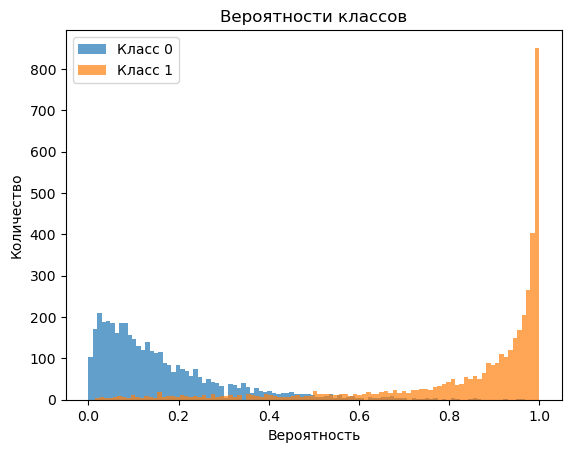

In [128]:
plt.hist(pdD[pdD['y_val']==0].pred, bins=100, alpha=0.7, label='Класс 0')
plt.hist(pdD[pdD['y_val']==1].pred, bins=100, alpha=0.7, label='Класс 1')
plt.title('Вероятности классов')
plt.xlabel('Вероятность')
plt.ylabel('Количество')
plt.legend()
plt.show()



In [129]:
# Лучшая модель - RandomForestClassifier

get_report(pipe=pipe_rforest, x_test=x_val, y_test=y_val)
print() 

y_test -  Counter({1: 4056, 0: 4056})
predictions -  Counter({0: 4324, 1: 3788})

roc_auc_score - 0.9726
Gini -  0.9453

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      4056
           1       0.96      0.90      0.93      4056

    accuracy                           0.93      8112
   macro avg       0.93      0.93      0.93      8112
weighted avg       0.93      0.93      0.93      8112




[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


In [131]:
predictions_proba = pipe_rforest.predict_proba(x_val)[:, 1]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


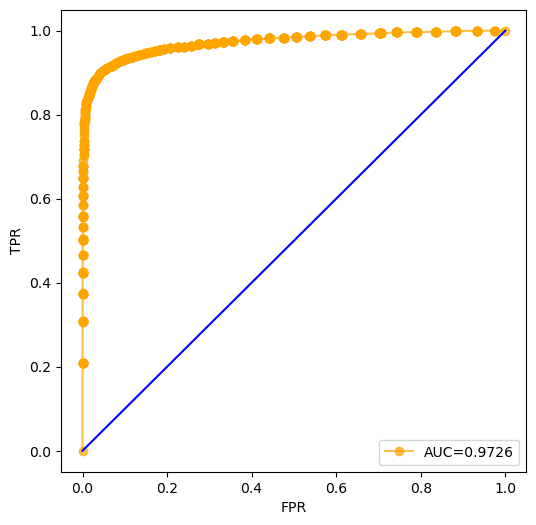

In [144]:
from sklearn.metrics import roc_curve

y_pred = pipe_rforest.predict_proba(x_val)[:, 1]
fpr, tpr, threshhold = roc_curve(y_val, y_pred, drop_intermediate=False)
auc = round(roc_auc_score(y_val, y_pred), 4)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='AUC=' + str(auc), color='orange', marker='o', alpha=0.7)
plt.plot([1, 0], [1, 0], color='blue')
plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

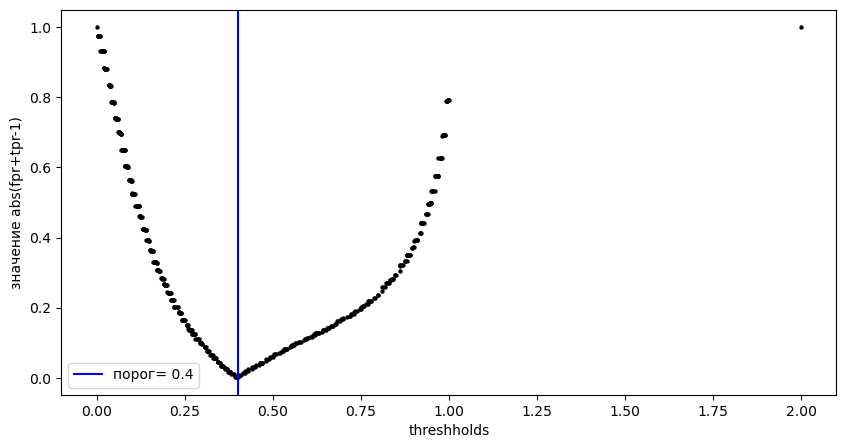

Optimal threshhold: 0.4


In [143]:
plt.figure(figsize=(10, 5))
plt.scatter(x=threshhold, y=abs(fpr+tpr-1), s=10, c='black', linewidth=0)
plt.axvline(threshhold[np.argmin(np.abs(fpr+tpr-1))], 
            color='blue', 
            label=f'порог= {threshhold[np.argmin(np.abs(fpr+tpr-1))]}')

plt.ylabel('значение abs(fpr+tpr-1)')
plt.xlabel('threshholds')
plt.legend()
plt.show()

print('Optimal threshhold:', threshhold[np.argmin(np.abs(fpr+tpr-1))])

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_y_pred = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_val, cm_y_pred, labels=[0, 1])

# confusion_matrix со стандартным порогом 0.5
cm

array([[3900,  156],
       [ 424, 3632]], dtype=int64)

In [137]:
cm_y_pred = np.where(y_pred > 0.4, 1, 0)

cm = confusion_matrix(y_val, cm_y_pred, labels=[0, 1])

# confusion_matrix with threshhold=0.4
cm

array([[3755,  301],
       [ 326, 3730]], dtype=int64)

## 4.3 Выводы

**Способы улучшения моделей:**

*Способы именно для этого датасета

> В целом, не было сильной разницы в метриках после использования optuna: RandomForestClassifier с базовыми параметрами обучается так же, как и LGBMClassifier + optuna

> Линейная и логистическая регрессии должны улавливать линейную зависимость с таргетом для высоких результатов. Для этого надо или выбирать только такие признаки, или создавать новые из имеющихся. Использование PolynomialFeatures подняло с 0.71 до 0.82 AUC, но сама корреляция с таргетом была меньше 0.1

> Стоит отметить методы undersampling и oversampling для балансировки классов. В прошлом датасете было много строк, там логично было бы использовать undersampling, но падало качество. В этой работе 24_000 строк - мало, увеличение до 40_000
оказало положительный эффект. В AutoML качество поднялось с 0.71 до 0.95

> Добавление новых признаков. В новом датасете использовались средние, медианные значения, суммы признаков. На графиках важности признаков видно, что они тоже влияют на оценку

> Очистка данных. Например, в столбце процентной ставки много значений 0%. Удалять их - терять данные (уже 24_00 строк),
заполнять средним или медианой - у каждого клиета разные кредиты